In [1]:
# Test logistic regression when dropping repeat codes in diagnosis
# Should be much worse than previous LR
# Dropping repeat codes also stops the strategy of just guessing earlier codes

# Added get subject age, sex, bmi

import json

work_loc = '/run/media/anton/Elements/UKB'

# Get number of codes

with open(f'{work_loc}/codes.json', 'r') as f:
    codes = json.load(f)
    D = len(codes)
    print(D)

with open(f'{work_loc}/eidCodesMapDropRepeats.json', 'r') as f:
    eidCodesMap = json.load(f)

print(len(eidCodesMap))

for k in eidCodesMap:
    print(eidCodesMap[k])
    break

1558
33204
[[870, 881], [748]]


In [2]:
# Get age sex bmi 

import pandas as pd

demofile = '/run/media/anton/Elements/UKB/AgeSexDemographics_participant.csv'

df = pd.read_csv(demofile)
df

,eid,p21022,p31,p22189,p50_i0,p21002_i0
0,5869068,62,Female,-3.11,157.0,70.8
1,1285065,57,Male,5.33,191.0,107.1
2,3875604,56,Male,-4.27,188.0,80.1
3,2324036,49,Female,0.74,161.0,88.4
4,1063851,59,Female,-4.75,155.0,59.7
...,...,...,...,...,...,...
502138,4305653,62,Female,-4.26,158.0,71.3
502139,2536038,41,Female,5.27,163.0,80.1
502140,3768226,48,Female,0.41,158.0,49.7
502141,2018360,70,Male,-1.48,175.0,89.8


In [3]:
# Create input data for LR
# x is one-hot of previous codes
# y is one-hot of last code

import numpy as np

x = []
y = []
keys = []

for k,v in eidCodesMap.items():
    if len(v) < 2:
        continue
    xone = np.zeros(D)
    yone = np.zeros(D)
    for i in range(len(v)-1):
        for code in v[i]:
            xone[code] = 1
    for code in v[-1]:
        yone[code] = 1
    x.append(xone)
    y.append(yone)
    keys.append(k)

x = np.stack(x)
y = np.stack(y)

print(x.shape)
print(y.shape)

(26710, 1558)
(26710, 1558)


In [7]:
demo_info = np.zeros((26710,3))

for i,k in enumerate(keys):
    row = df[df['eid'] == int(k)]
    age = row['p21022'].iloc[0]
    sex = int(row['p31'].iloc[0] == 'Male')
    weight = row['p21002_i0'].iloc[0]
    height = row['p50_i0'].iloc[0] / 100
    bmi = weight / (height**2)
    demo_info[i,0] = age if not np.isnan(age) else 0
    demo_info[i,1] = sex if not np.isnan(sex) else 0
    demo_info[i,2] = bmi if not np.isnan(bmi) else 0

x = np.concatenate([x, demo_info], axis=1)

print(demo_info[:5])
print(x.shape)

[[63.          0.         28.0859375 ]
 [43.          0.         25.61719215]
 [59.          1.         24.33404873]
 [62.          0.         24.66922443]
 [64.          0.         25.3837072 ]]
(26710, 1561)


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

xtr, xt, ytr, yt = train_test_split(x, y, train_size=20000)

for i in range(ytr.shape[1]):
    ytri = ytr[:,i]
    yti = yt[:,i]
    if not ytri.any() or not yti.any():
        continue
    reg = LogisticRegression(C=1000, max_iter=1000).fit(xtr, ytri)
    # logits = reg.predict_proba(xt)
    yhat = reg.predict(xt)
    acc = np.sum(yti == yhat)/len(yti)
    tn, fp, fn, tp = confusion_matrix(yti, yhat).ravel()
    sp = tn / (tn+fp)
    sn = tp / (tp+fn)
    fs = 2*tp / (2*tp + fp + fn)
    # auroc = roc_auc_score(yti, logits[:,1])
    print(i, codes[i], fs, sp, sn)

1 A02 0.0 1.0 0.0
3 A04 0.0 0.999850723988655 0.0
7 A08 0.0 1.0 0.0
8 A09 0.015267175572519083 0.9930576516752189 0.011904761904761904
17 A41 0.0 0.997159515622664 0.0
21 A49 0.0 0.9997018485390579 0.0
25 A63 0.0 1.0 0.0
37 B00 0.0 1.0 0.0
39 B02 0.0 0.9998508798091261 0.0
41 B07 0.0 0.9998508130687752 0.0
47 B18 0.0 1.0 0.0
56 B34 0.0 0.9980597014925373 0.0
57 B35 0.0 1.0 0.0
59 B37 0.0 0.9989542874215716 0.0
72 B82 0.0 1.0 0.0
80 B95 0.0 0.9991044776119403 0.0
81 B96 0.05 0.9973090148004186 0.047619047619047616
82 B97 0.0 0.9983582089552239 0.0
83 B98 0.0 0.9991042102120036 0.0
84 B99 0.0 1.0 0.0
86 C01 0.0 1.0 0.0
91 C07 0.0 1.0 0.0
98 C16 0.0 1.0 0.0
100 C18 0.0 0.9997016261375503 0.0
101 C19 0.0 1.0 0.0
102 C20 0.0 1.0 0.0
107 C25 0.0 1.0 0.0
113 C34 0.0 0.9995525059665871 0.0
117 C43 0.0 0.9989538185622477 0.0
118 C44 0.025974025974025976 0.9957485575463103 0.016129032258064516
122 C49 0.0 1.0 0.0
123 C50 0.0 0.9968496849684968 0.0
127 C54 0.0 0.9997016261375503 0.0
129 C56 0.0 1

In [17]:
# Read all non-zero F score results

with open('/run/media/anton/Elements/UKB/lr1000_results.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        parts = line.split()
        fscore = float(parts[2])
        if fscore > 0:
            print(line, end='')

17 A41 0.13793103448275862 0.9988043640711404 0.10526315789473684
123 C50 0.030303030303030304 0.9975979582645248 0.02040816326530612
132 C61 0.028169014084507043 0.9966976883818673 0.020833333333333332
176 D12 0.02197802197802198 0.9905946601941747 0.01694915254237288
187 D23 0.06666666666666667 0.9985054550889254 0.05263157894736842
244 E03 0.01904761904761905 0.9971320754716981 0.011764705882352941
281 E78 0.0196078431372549 0.9904158293399289 0.012448132780082987
284 E83 0.06060606060606061 0.997907949790795 0.05555555555555555
288 E87 0.05063291139240506 0.9953481392557023 0.043478260869565216
310 F32 0.016129032258064516 0.9945643967990336 0.011494252873563218
315 F41 0.015037593984962405 0.9957614290039358 0.009615384615384616
317 F43 1.0 1.0 1.0
378 G56 0.031746031746031744 0.9978985289702792 0.020833333333333332
422 H25 0.017391304347826087 0.9921934792591459 0.011299435028248588
423 H26 0.10380622837370242 0.9915267293175165 0.0684931506849315
428 H33 0.09523809523809523 0.99

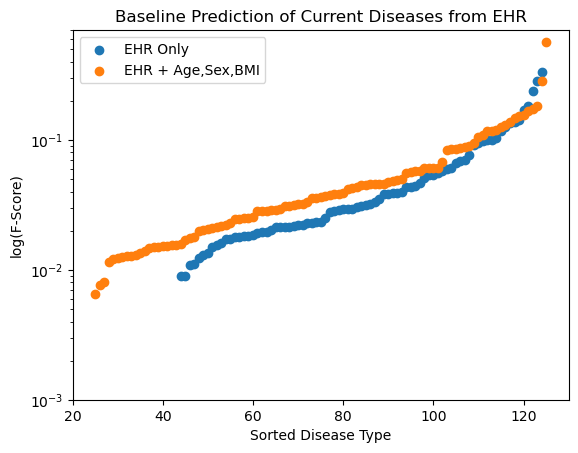

In [19]:
results0 = np.zeros(D)
results1 = np.zeros(D)

with open('/run/media/anton/Elements/UKB/lr1000_results.txt', 'r') as f:
    lines0 = f.readlines()
    for line in lines0:
        p = line.split()
        idx = int(p[0])
        f = float(p[2])
        results0[idx] = f

with open('/run/media/anton/Elements/UKB/lr1000_demo_results.txt', 'r') as f:
    lines1 = f.readlines()
    for line in lines1:
        p = line.split()
        idx = int(p[0])
        f = float(p[2])
        results1[idx] = f

sig_results0 = []
sig_results1 = []

for r0, r1 in zip(results0, results1):
    if r0 > 0 or r1 > 0:
        sig_results0.append(r0)
        sig_results1.append(r1)

sig_results0.sort()
sig_results1.sort()

import matplotlib.pyplot as plt

plt.scatter(np.arange(len(sig_results0)), sig_results0, label='EHR Only')
plt.scatter(np.arange(len(sig_results1)), sig_results1, label='EHR + Age,Sex,BMI')

plt.xlim([20,130])
plt.ylim([0.001,0.7])
plt.legend()
plt.yscale('log')

plt.ylabel('log(F-Score)')
plt.xlabel('Sorted Disease Type')

plt.title('Baseline Prediction of Current Diseases from EHR')

plt.show()